In [1]:
using Pkg
Pkg.activate((@__DIR__) * "/../../muc_venv")

using Revise
using LinearAlgebra
using LaTeXStrings
using DelimitedFiles: readdlm
using DataFrames
using CSV
using Interpolations
using PythonPlot
using PythonCall
mpl = pyimport("matplotlib")
pe = pyimport("matplotlib.patheffects")
using NaturallyUnitful

rc("font", family="serif", serif="Computer Modern", size=14)
rc("figure", autolayout=true)
rc("axes", labelsize=16, unicode_minus=false)
rc("text", usetex=true)
rc("text.latex", preamble=raw"\usepackage{slashed}")

golden_ratio = (1+sqrt(5))/2
to_cm_ns = ustrip(unnatural(u"cm*ns^-1", 1))
GeV_to_ns = ustrip(unnatural(u"ns", 1*u"GeV^-1"))
ccms = ustrip(unnatural(u"cm*s^-1", 1))

FIGDIR = "./"
BOLTZ = "./boltz_outs/"

# make sure these match what the script has output
MG_RESULTS_DIR = "/home/aradick/Downloads/Madgraph/3_5_6/uR_dynamic/"
DIR_mumu_LR = "mumu_to_phiphi_LR/"
DIR_mumu_RL = "mumu_to_phiphi_RL/"
DIR_VV = "VV_to_phiphi/"

RUN_RESULTS_FILENAME = "run_info.csv"
SUMMARY_FILENAME = "diphi_summary.csv"
;

  Activating project at `~/Dropbox (University of Oregon)/research/flavorDM2/Aria/muc_venv`


In [2]:
includet("../../muc_venv/LLP_utils.jl")
using .LLP_Utils
;

In [3]:
run_infos = get_runs_info(MG_RESULTS_DIR, DIR_mumu_LR, DIR_mumu_RL, DIR_VV);

In [4]:
nopdf_info = nopdf_run_info(run_infos);

In [15]:
mφ_for_bounds = mphi_for_bound = 10 .^ range(2, 5, 100)
mχ_upper = readdlm(BOLTZ * "mchi_upper.csv")[:]
;

In [6]:
mchi_lhc = readdlm(BOLTZ * "mchi_llp_limit.csv")[:]
mphi_lhc = readdlm(BOLTZ * "mphi_llp_limit.csv")[:]
;

In [19]:
function make_money(events_in_detector)
    eid = events_in_detector
    title = L"Number of Expected Events ($u$ Model)"

    fig, axs = subplots(4,2,figsize=(10,12))

    mphi_plot = 10 .^ range(log10(eid.mphis[1]), log10(eid.mphis[end]), 100)
    mchi_plot = 10 .^ range(log10(eid.mchis[1]), log10(eid.mchis[end]), 100)

    cmap = mpl.cm.Purples
    bounds = -1.0:1.0:3.0
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend="both")
    
    idx = 1
    for ax in axs
        for a in ax
            q = transpose(sum(eid.N_exp[idx,:,:,:];dims=2)[:,1,:])
            # for i in eachindex(eid.mphis)
            #     t = @view q[i,:]
            #     u = t[[!isnan(x) for x in t]]
            #     t[isnan.(t)] .= u[end]
            # end

            g = a.pcolormesh(eid.mchis, eid.mphis, log10.(q), norm=norm,
                            cmap=cmap)
            a.fill_betweenx(mφ_for_bounds, mχ_upper, 1e4, color="gainsboro", 
                            zorder=2)
            
            a.fill_between(mchi_lhc, mphi_lhc, edgecolor="xkcd:neon green",
                            facecolor="none")

            # a.fill_betweenx(Mphis_hscp, mχ_hscp, mχ_hscp_upper, 
            #             edgecolor="xkcd:neon pink", facecolor="none")
            
            # a.fill_betweenx(seR_mphis, seR_lo_mχ, seR_hi_mχ, edgecolor="xkcd:neon green",
            #                 facecolor="none")
            
            formatter(l) = L"10^{ %$(Int(l)) }"

            a.set_xscale("log")
            a.set_yscale("log")
            a.set_xlim(eid.mchis[1], eid.mchis[end])
            a.set_ylim(1e2, eid.rts/2)
            cbar = fig.colorbar(g)
            cbar.ax.set_yticklabels(formatter.(bounds))
            a.set_title("Decays $(eid.labels[idx])")
            a.set_xlabel(L"$m_\chi$ [GeV]")
            a.set_ylabel(L"$m_\phi$ [GeV]")

            idx += 1
        end
    end

    fig.suptitle(title)

    plotclose()

    return fig
end
;

In [35]:
function make_money_τφ(eid_nopdf, eid_pdf; eid_labs=["No PDF + EVA", "LePDF + EVA"])
    eids = [eid_nopdf, eid_pdf]
    title = L"Number of Expected Events ($e_R$ Model)"
    # title = L"$\ell_R$ Model Number of Expected Events ($i = \mu \mu$ only)"

    fig, axs = subplots(4,2,figsize=(10,12))

    # mphi_plot = 10 .^ range(log10(eid_pdf.mphis[1]), log10(eid_pdf.mphis[end]), 100)

    cmap = mpl.cm.Purples
    bounds = -1.0:1.0:4.0
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend="both")
    
    for (idx,ax) in enumerate(axs)
        for (i,a) in enumerate(ax)
            eid = eids[i]
            q = sum(eid.N_exp[idx,:,:,:];dims=2)[:,1,:]

            g = a.pcolormesh(1e-3 .* eid.mphis, eid.tauphis[1,:], log10.(q), norm=norm,
                            cmap=cmap)

            # a.fill_between(1e-3 .* Mphis_hscp, 1.0, 1e15, edgecolor="xkcd:neon pink", facecolor="none")
            
            # a.fill_between(1e-3 .* seR_mphis, 1e9*seR_lo_τφ, 1e9*seR_hi_τφ, edgecolor="xkcd:neon green",
            #                 facecolor="none")
            
            formatter(l) = L"10^{ %$(Int(l)) }"

            # a.set_xscale("log")
            a.set_yscale("log")
            a.set_ylim(eid.tauphis[1], eid.tauphis[end])
            a.set_xlim(1e-3 .* 1e2, 1e-3 .* eid.rts/2)
            cbar = fig.colorbar(g)
            cbar.ax.set_yticklabels(formatter.(bounds))
            a.set_title("Decays $(eid.labels[idx])")
            a.set_ylabel(L"$\tau_\phi$ [ns]")
            a.set_xlabel(L"$m_\phi$ [TeV]")

            props = Dict("boxstyle"=>"round", "facecolor"=>"white", "alpha"=>1)
            a.text(0.975, 0.05, "$(eid_labs[i])", transform=a.transAxes, 
                fontsize=12, verticalalignment="bottom", horizontalalignment="right",
                bbox=props)

            a.grid(alpha=0.3)
        end
    end

    fig.suptitle(title)

    plotclose()

    return fig
end

function money_diff(eid_nopdf, eid_pdf)
    fig = figure()

    # cmap = mpl.cm.Purples
    cmap = mpl.cm.magma_r
    # cmap = mpl.cm.cividis
    # cmap = mpl.cm.Blues
    # bounds = -4.0:1.0:0.0
    bounds = [0.01, 0.05, (0.1:0.2:1.0)...]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend="both")

    q1 = sum(eid_nopdf.N_exp[1,:,:,:];dims=2)[:,1,:]
    q2 = sum(eid_pdf.N_exp[1,:,:,:];dims=2)[:,1,:]

    diff = @. abs((q1-q2)/q2)

    g = pcolormesh(1e-3 .* eid_pdf.mphis, eid_pdf.tauphis[1,:],
                diff, cmap=cmap, norm=norm)

    # formatter(l) = L"10^{ %$(Int(l)) }"
    formatter(l) = L"%$(round(Int,1e2*l)) \%"

    a = gca()

    # a.set_xscale("log")
    a.set_yscale("log")
    a.set_ylim(eid_pdf.tauphis[1], eid_pdf.tauphis[end])
    a.set_xlim(1e-3 .* 1e2, 1e-3 .* eid_pdf.rts/2)
    cbar = fig.colorbar(g)
    cbar.ax.set_yticklabels(formatter.(bounds))
    a.set_title("Decays $(eid_pdf.labels[1])")
    a.set_ylabel(L"$\tau_\phi$ [ns]")
    a.set_xlabel(L"$m_\phi$ [TeV]")

    a.grid(alpha=0.3)

    title("Diffs")

    plotclose()

    return fig
end

money_diff (generic function with 1 method)

In [28]:
tauphis_money = 10 .^ range(-3, 4, 50);

In [32]:
eid1 = eid_tauphi(run_infos, 10e6, tauphis_money; det_comps=[1,2,5,7])

(N_exp = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0

In [33]:
eid2 = eid_tauphi(nopdf_info, 10e6, tauphis_money; det_comps=[1,2,5,7])

(N_exp = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; … ;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0

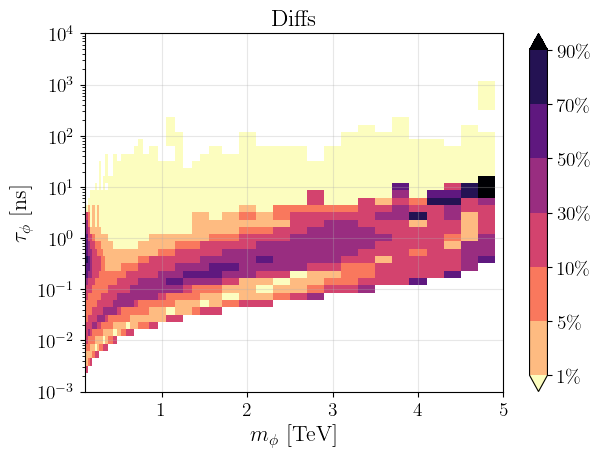

In [105]:
f = money_diff(eid2,eid1)
f.savefig("money_diff.pdf")
f

In [ ]:
f = make_money_τφ(eid2,eid1)
f.savefig("eR_LLP_diff.png", bbox_inches="tight", dpi=400)
f

In [8]:
mchis = readdlm(BOLTZ * "mchis_grid.csv")[:]
tauphis = readdlm(BOLTZ * "phi_lifetimes_sec.csv")[1:end-1,:] .* 1e9
;

In [18]:
eid_m = eid_mchi(run_infos, 10e6, mchis, tauphis)

(N_exp = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.07477799096507215 … 0.0 0.0; 1299.641482972954 1299.641482972954 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.889106168170587 0.4149162118129406 … 0.0 0.0; 516.2150412398428 516.8077786852898 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 8.442303945339455 3.686076370500326 … 0.0 0.0; … ; 51.36725780826261 60.04737313234402 … 0.0 0.0; 686.5614504280285 715.4555329451762 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 3.4819499999999994 1.6713359999999997 … 0.0 0.0; … ; 23.120147999999997 26.149444499999998 … 0.0 0.0; 270.75643199999996 282.94325699999996 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.01869185540943181 … 0.0 0.0; 324.8831388713343 324.8831388713343 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.11439166362826048 0.02859791590706512 … 0.0 0.0; 129.87743509193623 129.96322883965743 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 1.4637241540900148 0.7749127874594196 … 0.0 0.0; … ; 13.532273306930234 15.770910248479668 … 0.0 0

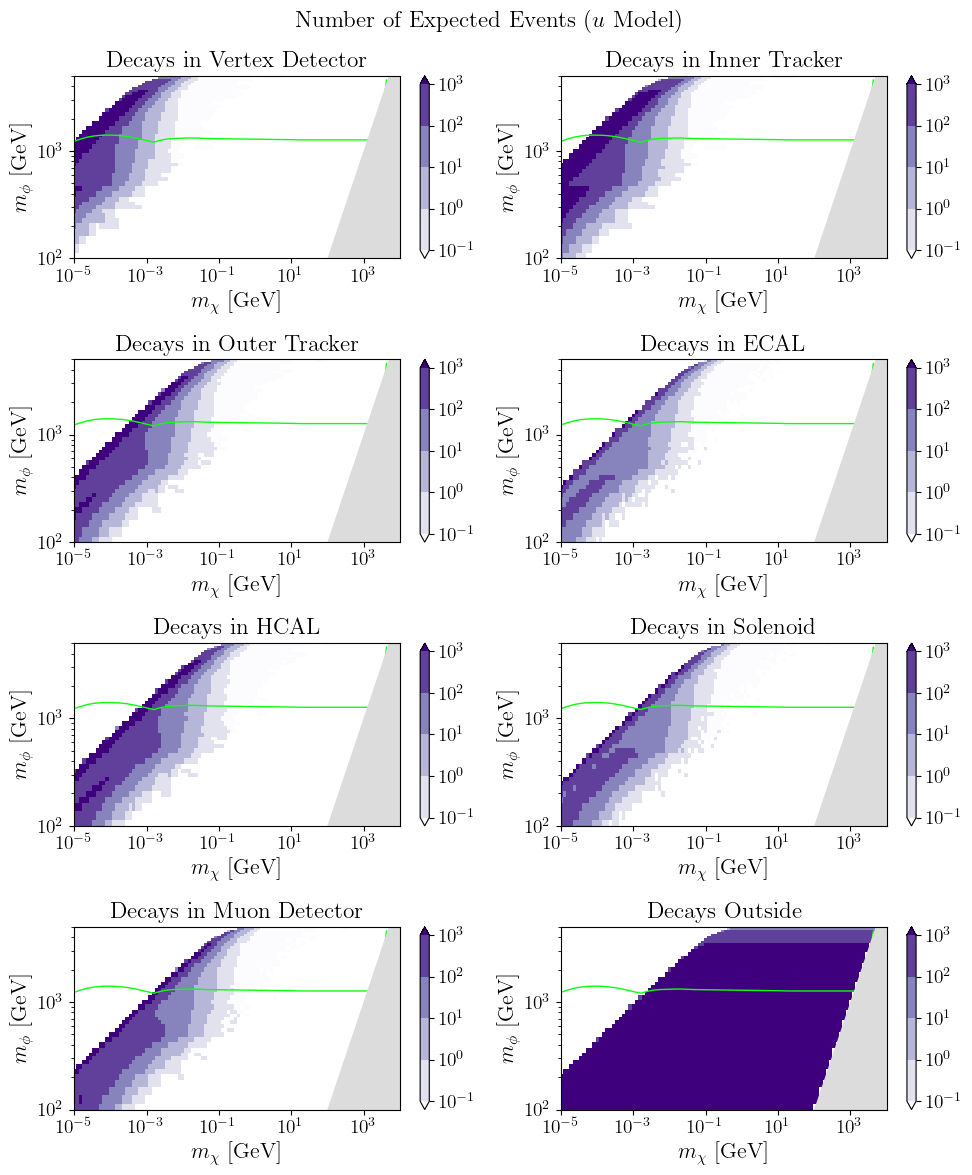

In [20]:
f = make_money(eid_m)
f.savefig("uR_LLP_events_mchi.png", bbox_inches="tight", dpi=400)
f